# 0. Imports

In [140]:
############## FUNDAMENTAL MODULES ################
import json
from PIL import Image
import os
import sys
import copy
import matplotlib.pyplot as plt
 ##################################################


############## TASK-SPECIFIC MODULES ##############
sys.path.append(os.path.join(os.getcwd(),"src"))
###################################################


############## DATA SCIENCE & ML MODULES ##########
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel
import torch
###################################################


In [37]:
# Load the training set (raw data)
dataset_directory = "/Users/onurdenizguler/Library/CloudStorage/GoogleDrive-check.worthiness@gmail.com/My Drive/data/CT23_1A_checkworthy_multimodal_english_v1"
train_jsonl_file = os.path.join(dataset_directory, "CT23_1A_checkworthy_multimodal_english_train.jsonl")

train_set = []
with open(train_jsonl_file, "r") as f:
    for line in f:
       train_set.append(json.loads(line))

Text(0.5, 1.0, 'Original image and tweet')

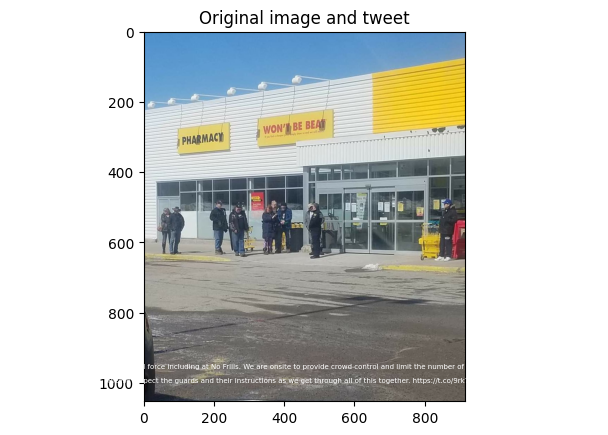

In [137]:
# Examine a single sample from the training set
sample = train_set[0]
tweet_id = sample["tweet_id"]
tweet_text = sample["tweet_text"]
tweet_url = sample["tweet_url"]
img_path = os.path.join(dataset_directory, sample["image_path"])
img = Image.open(img_path)

fig, ax = plt.subplots()
#fig.set_size_inches(15, 15)
ax.imshow(img)
ax.text(0.5, 0.05, tweet_text, transform=ax.transAxes,
        fontsize=5, ha='center', color='white')
plt.title("Original image and tweet")

# <font color="Crimson"> Use the model to embed a single sample from the train set

<font color="Black"> In this implementation we use the following model: "clip-vit-base-patch32". This model differs from the paper implementation in that it uses ViT instead of ResNet. https://huggingface.co/openai/clip-vit-base-patch32

In [ ]:
device = "cuda" if torch.cuda.is_available() else \
         ("mps" if torch.backends.mps.is_available() else "cpu")
model_id = "openai/clip-vit-base-patch32"
tokenizer = CLIPTokenizerFast.from_pretrained(model_id)
processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id).to(device)

### <font color="Crimson"> Tokenize and embed the tweet

In [141]:
# Collect all train/dev/test tweets and images
sample1, sample2 = train_set[1], train_set[2]
tweet_id1, tweet_id1 = sample1["tweet_id"], sample2["tweet_id"]
tweet_text1, tweet_text2  = sample1["tweet_text"], sample2["tweet_text"]
tweet_url1, tweet_url2 = sample1["tweet_url"], sample2["tweet_url"]
img_path1, img_path2 = os.path.join(dataset_directory, sample1["image_path"]), os.path.join(dataset_directory, sample2["image_path"])
img1, img2 = Image.open(img_path1), Image.open(img_path2)

In [ ]:
batch_txts = texts[i:i+batch_size]
inputs = tokenizer(batch_txts, return_tensors="pt").to(device)
batch_txt_emb = model.get_text_features(**inputs)

In [114]:
# Create tokens from the tweet text
inputs = tokenizer(tweet_text, return_tensors="pt").to(device)
print("Tokens: ", inputs)

# Embed the tokenized tweet as a single entity into a 512-dim space
text_emb = model.get_text_features(**inputs)
print("\nEmbedding shape: ", text_emb.shape)

Tokens:  {'input_ids': tensor([[49406,   581,  1027,   530, 20761,  2553,   533, 20009,  1476,  2869,
          2814,   536,   871,   936,  1900,   269,   649,   631, 37336,   531,
          4832,  4570,  3366,   537,  9973,   518,  2842,   539,  1047,   530,
           518,  2183,   536,  1504,  4302,   788,   269,  1474,  4916,   518,
         12810,   537,   911, 17040,   601,   649,   779,  1417,   615,   539,
           589,  1952,   269, 30901, 12441,   339,   269,  1320,   270,   280,
         21422,   278,   619,   342,   271,  3996, 49407]], device='mps:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='mps:0')}

Embedding shape:  torch.Size([1, 512])


### <font color="Crimson"> Process and embed the image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original image shape (width, height):  (914, 1053)
Resized image shape:  torch.Size([1, 3, 224, 224])


Text(0.5, 1.0, 'Image after processor transformation')

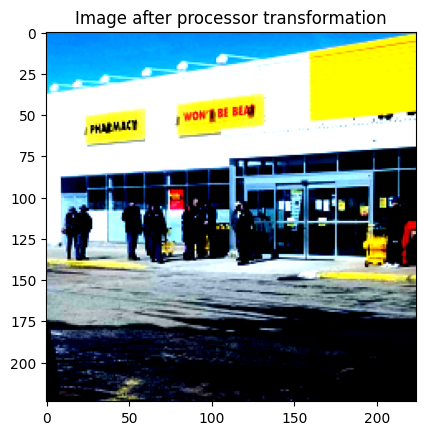

In [138]:
# Resize the image using the processor
image = processor(
    text=None,
    images=img,
    return_tensors='pt'
)['pixel_values'].to(device)
print("Original image shape (width, height): ", img.size)
print("Resized image shape: ", image.shape)

# Display the transformed image
tensor_image_to_display = copy.deepcopy(image)
tensor_image_to_display = tensor_image_to_display.to("cpu")
tensor_image_to_display = tensor_image_to_display.squeeze()
plt.imshow(tensor_image_to_display.permute(1, 2, 0))
plt.title("Image after processor transformation")

In [139]:
# Embed the transformed image
img_emb = model.get_image_features(image)
print("Image embedding shape: ", img_emb.shape)

Image embedding shape:  torch.Size([1, 512])
